<a href="https://colab.research.google.com/github/thattesv5/ProgrammingAssignment2-Lexical-Scoping/blob/master/VCopyy_of_Final_Project_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import Libraries
import pandas as pd
from google.colab import drive
import seaborn as sns
import matplotlib
#import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import FunctionTransformer

In [3]:
  #Importing Irrigation data by site
  # irrigation file link: 
  # https://drive.google.com/file/d/1UWClsVao268yHNcX4HJUrK6IK1gOOoPr/view?usp=sharing

IRRIGATION = pd.read_csv("https://drive.google.com/uc?export=download&id=1UWClsVao268yHNcX4HJUrK6IK1gOOoPr",
                         parse_dates = ["Day 1"])

In [4]:
   #Importing Fertilizer data by site
  # nitrogen file link:
  # https://drive.google.com/file/d/1ObrxpIAGni1n5veQR7XUOdtR5l3Zpff3/view?usp=sharing
  

NITROGEN = pd.read_csv("https://drive.google.com/uc?export=download&id=1ObrxpIAGni1n5veQR7XUOdtR5l3Zpff3",header=None)

# reformat df for further processing
cols = list(NITROGEN[0].values)
#print(nitrogen)
NITROGEN = np.transpose(NITROGEN)
#print( nitrogen)
NITROGEN.columns = cols
NITROGEN = NITROGEN.drop([0,7],axis=0)
NITROGEN["date"] = pd.to_datetime(NITROGEN["Farm ID"])

In [5]:
#Setting our date range- 11 starts the latest so we start the other plots on that day also
#constrain data sets to match 11a (location with the smallest range of data)
plot_11_a = pd.read_csv("https://drive.google.com/uc?export=download&id=1uKiwPGX4PkjtVTUhMJk1gzg4H_wb2KPy",
                        parse_dates = ["local_device_time"])
DATES = plot_11_a["local_device_time"].values
# mask to dates before 10-30 (harvest)
harvest = pd.to_datetime("10/31/2020")
harvest_mask = DATES <= harvest
DATES = DATES[harvest_mask]

In [6]:
#Functions to merge irrigation and nitrogen data sets and joins on date
def import_data(lnk):
  return pd.read_csv(lnk,parse_dates = ["local_device_time"])

def trim_dates(df, dates):
  mask = df["local_device_time"].isin(dates)
  df = df[mask]
  return df.reset_index(drop=True)

def join_reps(a,b):
  return pd.concat([a,b]).groupby(level=0).mean()

def add_irrigation(df,irr,farm):
  farm_id = 'Farm ' + str(farm)
  plot_irr = irr[['Day 1',farm_id]]
  plot_irr.columns = ['local_device_time','irr_amount']

  plot_irr['irr_amount'] = plot_irr['irr_amount']*25.4

  df = df.merge(plot_irr, on='local_device_time', how='left')
  
  return df.replace(np.NaN, 0)

# Add Nitrogen ammounts
def add_n(plot_df, nitrogen, farm):
  plot_df['n_total'] = 0
  ndf = nitrogen[["date",str(farm)]]
  total = 0
  for idx, d in enumerate(ndf["date"]):
    total += float(ndf.loc[idx+1,str(farm)])
    mask = plot_df["local_device_time"] > d
    plot_df["n_total"][mask] = total

  return plot_df

# add running total for irrigation
def add_irr_total(plot_df):
  plot_df['irr_total'] = 0
  total = 0
  for idx, i in enumerate(plot_df["irr_amount"]):
    total += i 
    plot_df["irr_total"][idx] = total

  return plot_df

# add total water input
def add_total_water(plot_df):
  plot_df['total_water_input'] = plot_df['precip'] + plot_df['irr_amount']
  return plot_df
  
# convert F to C
def convert_to_C(df, col):
  df[col] = (df[col]-32)*5/9
  return df


In [7]:
#Trying to add one more column - a new water balance
def add_water_balance(plot_df):
  plot_df['water_balance'] = plot_df['total_water_input'] - plot_df['ETc']
  return plot_df

In [8]:
#One larger function to run all of the smaller ones
def load_clean_data(lnk_a, lnk_b, plot, dates, irrigation, nitrogen):
  df_a = import_data(lnk_a)
  df_b = import_data(lnk_b)
  df_a = trim_dates(df_a, dates)
  df_b = trim_dates(df_b, dates)

  df = join_reps(df_a, df_b)
  df['local_device_time'] = df_a['local_device_time']
  df = add_irrigation(df, irrigation, plot)
  df = add_n(df, nitrogen, plot)
  df = add_irr_total(df)
  df = add_total_water(df)
  df = add_water_balance(df)

  df = convert_to_C(df, 'max_temp')
  df = convert_to_C(df, 'mean_temp')

  return df 

In [17]:
#the sources of the Daily data
lnk_3_a = "https://drive.google.com/uc?export=download&id=16Exv9Df14QLZZrXjaoJ6nTp8CU5yB0RJ"
lnk_3_b = "https://drive.google.com/uc?export=download&id=1rR2LN4zZviTatNTca4olPKHrM96jCyvY"

lnk_5_a = "https://drive.google.com/uc?export=download&id=1BIrR5f9H0vnBT-5HSi0UCTluj2kk7I1W"
lnk_5_b = "https://drive.google.com/uc?export=download&id=1O_bQWdwOqOb1U4OuWa15ct_WNj612x1X"

lnk_11_a = "https://drive.google.com/uc?export=download&id=1uKiwPGX4PkjtVTUhMJk1gzg4H_wb2KPy"
lnk_11_b = "https://drive.google.com/uc?export=download&id=1SjD064dySTIp9EKDxVP_0daJwloWBbXj"

lnk_16_a = "https://drive.google.com/uc?export=download&id=1kPh5aQEEbnR0mHM6You7wUW4RDOPEorT"
lnk_16_b = "https://drive.google.com/uc?export=download&id=1YbuTKswxV5sGOKmr8KHRi-JltbCPaLyt"

In [27]:
#linking sites a and b - linking small functions and cleaning on dates, irrigation,  nitrogen
plot_3 = load_clean_data(lnk_3_a, lnk_3_b, 3, DATES, IRRIGATION, NITROGEN)
plot_5 = load_clean_data(lnk_5_a, lnk_5_b, 5, DATES, IRRIGATION, NITROGEN)
plot_11 = load_clean_data(lnk_11_a, lnk_11_b, 11, DATES, IRRIGATION, NITROGEN)
plot_16 = load_clean_data(lnk_16_a, lnk_16_b, 16, DATES, IRRIGATION, NITROGEN)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

In [28]:
#Sources of the data for the Hourly data frames (used for Tbelow and noon air temp (air_temperature))
lnk_16_b_hr = "https://drive.google.com/uc?export=download&id=1i2MCKcEkN1QEgiF-9zqljzKx2jIbeV_U"
lnk_16_a_hr = "https://drive.google.com/uc?export=download&id=1EDGmENcfGP6YEwY11BCRGc7HnQl5isld"

lnk_11_b_hr = "https://drive.google.com/uc?export=download&id=1SjD064dySTIp9EKDxVP_0daJwloWBbXj"
lnk_11_a_hr = "https://drive.google.com/uc?export=download&id=12hWw3SaFWAr7sZmpRVH9AifGuDDmM1ki"

lnk_5_b_hr = "https://drive.google.com/uc?export=download&id=1eYmYrXuqJQNhQn7z74aY00DUbmn28qIR"
lnk_5_a_hr = "https://drive.google.com/uc?export=download&id=1oMFPqqt_cAB7-NXpCG44y0EYCzXSXiSB"

lnk_3_b_hr = "https://drive.google.com/uc?export=download&id=1A1a3xmqRwRMlYEdMC2WtJR07BwGIUVNU"
lnk_3_a_hr = "https://drive.google.com/uc?export=download&id=1nxGXkCd01q9tpjPQtLlCuARrBjuJH6ds"

In [29]:
# Function for adding tbelow and air_temp
def add_hourly(hr_lnk_a, hr_lnk_b, plot_df, dates):
  hr_df_a = pd.read_csv(hr_lnk_a, parse_dates = ["local_device_time"], usecols=['local_device_time','tbelow','air_temp'])
  hr_df_b = pd.read_csv(hr_lnk_b, parse_dates = ["local_device_time"], usecols=['local_device_time','tbelow','air_temp'])
  hr_df = pd.merge(hr_df_a, hr_df_b, how='inner', on='local_device_time')
  hr_df['tbelow'] = hr_df[['tbelow_x','tbelow_y']].mean(axis=1)
  hr_df = hr_df.drop(['tbelow_x','tbelow_y'], axis=1)
  hr_df['air_temp'] = hr_df[['air_temp_x','air_temp_y']].mean(axis=1)
  hr_df = hr_df.drop(['air_temp_x','air_temp_y'], axis=1)
  hr_df['hour'] = hr_df['local_device_time'].dt.time
  hr_df['local_device_time'] = hr_df['local_device_time'].dt.date 
  hour_mask = hr_df['hour'] == pd.to_datetime('12:00:00').time()
  hr_df = hr_df[hour_mask]
  hr_df['local_device_time'] = pd.to_datetime(hr_df['local_device_time'])
  hr_df = hr_df.drop('hour',axis=1)
  hr_df = trim_dates(hr_df, dates)
  hr_df = convert_to_C(hr_df, 'tbelow')
  hr_df = convert_to_C(hr_df, 'air_temp')
  return plot_df.merge(hr_df, on = 'local_device_time', how = 'left')

In [40]:
#merging air_temp and tbelow
plot_3 = add_hourly(lnk_3_b_hr, lnk_3_b_hr, plot_3, DATES)
plot_5 = add_hourly(lnk_5_a_hr, lnk_5_b_hr, plot_5, DATES)
plot_11 = add_hourly(lnk_11_a_hr, lnk_11_b_hr, plot_11, DATES)
plot_16 = add_hourly(lnk_16_b_hr, lnk_16_b_hr, plot_16, DATES)

HTTPError: ignored

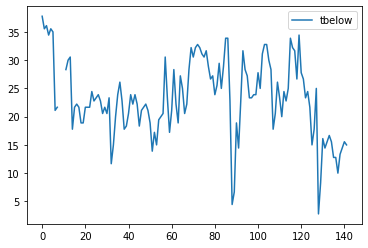

In [25]:
plot_16.plot(y='tbelow')

In [37]:
plot_3['lfairdelta'] = plot_3['tbelow'] - plot_3['air_temp']
plot_5['lfairdelta'] = plot_5['tbelow'] - plot_5['air_temp']
plot_11['lfairdelta'] = plot_11['tbelow'] - plot_11['air_temp']
plot_16['lfairdelta'] = plot_16['tbelow'] - plot_16['air_temp']

KeyError: ignored

In [35]:
#add a new function to create column that is a calculated field for Crop Water Stress Index
#Plot 16 is our least water stressed canopy (most irrigated) so we use that data in creating the DTll (differnetial temperature lower level)
#DTUL= degree threshold upper limit

#gives us a dataframe for each day
dTll = (-1.79*plot_16['vapor_pressure_deficit'])+2.34

#Function to create CWSI column
#CWSI - dtm[difference of canopy/airtemp]-DTll/dtul-DTll)
#dtm is leaf air detla
def calc_cwsi(df,dTll, dTUL = 5):
  df['CWSI'] = ((df['tbelow']-df['air_temp'])-dTll)/(dTUL-dTll)
  return df


In [36]:
#adding CWSI to the data frames
plot_16 = calc_cwsi(plot_16, dTll)
plot_11 = calc_cwsi(plot_11, dTll)
plot_3 = calc_cwsi(plot_3, dTll)
plot_5 = calc_cwsi(plot_5, dTll)

KeyError: ignored

In [ ]:
#handling nulls with mean
def fill_nans(df):
  return df.fillna(df.mean())
plot_11 = fill_nans(plot_11)
plot_16 = fill_nans(plot_16)
plot_5 = fill_nans(plot_5)
plot_3 = fill_nans(plot_3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:


from sklearn.preprocessing import Binarizer


In [ ]:
def add_is_water_stress (df):
  bn = Binarizer(threshold=0.9)
  is_water_stressed = bn.transform([df['CWSI']])[0]
  df['is_water_stressed'] = is_water_stressed
  return df
plot_11 = add_is_water_stress(plot_11)
plot_11.head(11)

,lat,long,cl,ET,ETc,gdd,gdd_source,gdd_cumulative,gdd_cumulative_source,NDVI,min_rh,rh_at_max_temp,rh_at_min_temp,swdw,max_temp,mean_temp,min_temp,max_temp_dew,precip,precip_hours,cumulative_precip,sea_level_pressure,vapor_pressure_deficit,Kc,leaf_wetness,dew_temp,crop_water_demand,sunshine_duration,wind_speed,wind_heading,wind_speed_max,wind_speed_min,local_device_time,irr_amount,n_total,irr_total,total_water_input,water_balance,tbelow,air_temp,lfairdelta,CWSI,is_water_stressed
0,41.08725,-100.771,2.475,3.770,2.075,0.0,0.0,0.0,0.0,0.520,0.220,0.235,0.505,26.0,23.611111,13.611111,45.5,43.0,0.000,0.0,0.000,508.15,15.80,0.580,0.0,30.0,-2.075,8.50,2,0.0,9,5,2020-06-12,0.0,152.2,0,0.000,-2.075,37.500000,34.722222,2.777778,0.956418,1.0
1,41.08725,-100.771,2.765,3.640,2.190,0.0,0.0,0.0,0.0,0.550,0.335,0.355,0.900,30.5,15.000000,9.166667,34.0,36.5,0.000,0.0,0.000,504.85,8.70,0.630,0.0,34.0,-2.190,11.20,3,0.0,15,6,2020-06-13,0.0,152.2,0,0.000,-2.190,34.166667,27.777778,6.388889,1.048537,1.0
2,41.08725,-100.771,3.165,3.430,2.295,0.0,0.0,0.0,0.0,0.595,0.220,0.225,0.425,23.5,18.333333,12.500000,45.0,33.5,0.000,0.0,0.000,502.10,14.70,0.695,0.0,29.5,-2.295,10.60,4,0.0,19,4,2020-06-14,0.0,152.2,0,0.000,-2.295,36.666667,31.111111,5.555556,1.011718,1.0
3,41.08725,-100.771,3.205,3.690,2.505,0.0,0.0,0.0,0.0,0.600,0.210,0.220,0.510,29.0,18.333333,12.222222,45.0,34.0,0.000,0.0,0.000,504.25,13.05,0.700,0.0,31.5,-2.505,10.80,3,0.0,15,5,2020-06-15,0.0,152.2,0,0.000,-2.505,34.166667,28.055556,6.111111,1.027005,1.0
4,41.08725,-100.771,3.530,3.795,2.660,0.0,0.0,0.0,0.0,0.620,0.295,0.300,0.610,29.5,17.222222,11.666667,43.5,36.0,0.000,0.0,0.000,502.65,12.50,0.735,0.0,33.0,-2.660,11.00,5,0.0,22,13,2020-06-16,0.0,152.2,0,0.000,-2.660,35.000000,30.000000,5.000000,1.000000,1.0
5,41.08725,-100.771,3.745,3.640,2.660,0.0,0.0,0.0,0.0,0.640,0.315,0.325,0.670,28.5,18.055556,12.222222,44.0,39.0,0.000,0.0,0.000,500.45,11.95,0.755,0.0,37.0,-2.660,11.45,4,0.0,23,11,2020-06-17,0.0,152.2,0,0.000,-2.660,33.888889,29.444444,4.444444,0.985211,1.0
6,41.08725,-100.771,4.530,2.440,1.980,0.0,0.0,0.0,0.0,0.695,0.365,0.525,0.710,21.5,11.944444,7.500000,38.0,39.0,0.000,0.0,0.000,504.25,6.55,0.835,0.0,31.5,-1.980,10.50,3,0.0,18,5,2020-06-18,0.0,152.2,0,0.000,-1.980,21.111111,19.444444,1.666667,0.856600,0.0
7,41.08725,-100.771,4.935,1.925,1.665,0.0,0.0,0.0,0.0,0.720,0.480,0.480,0.850,18.0,8.611111,5.000000,36.0,35.5,0.480,1.0,0.480,505.95,3.85,0.875,1.0,32.5,-1.185,9.20,2,0.0,8,1,2020-06-19,0.0,152.2,0,0.480,-1.185,21.666667,19.722222,1.944444,0.786250,0.0
8,41.08760,-100.771,5.510,0.240,0.220,0.0,0.0,0.0,0.0,0.750,0.330,0.410,0.970,29.0,28.333333,20.000000,54.0,59.0,0.000,0.0,0.060,916.00,10.00,0.920,7.0,56.0,-0.220,10.80,1,0.0,9,2,2020-06-20,0.0,152.2,0,0.000,-0.220,28.333333,23.333333,5.000000,1.000000,1.0
9,41.08760,-100.771,5.750,0.240,0.220,0.0,0.0,0.0,0.0,0.760,0.330,0.330,0.920,27.0,31.111111,22.222222,61.0,60.0,0.000,0.0,0.060,913.00,11.00,0.940,0.0,58.0,-0.220,10.90,2,0.0,11,4,2020-06-21,0.0,152.2,0,0.000,-0.220,31.111111,26.111111,5.000000,1.000000,1.0


In [ ]:
plot_16 = add_is_water_stress(plot_16)
plot_5 = add_is_water_stress(plot_5)
plot_3 = add_is_water_stress(plot_3)

In [ ]:
#Setting df index to date
plot_3.set_index('local_device_time',inplace=True)
plot_5.set_index('local_device_time',inplace=True)
plot_11.set_index('local_device_time',inplace=True)
plot_16.set_index('local_device_time',inplace=True)

In [ ]:
#For creating an NDVI ratio
#"def add_NDVI(df, ref = plot_16):
  #df["NDVI"] = df["NDVI"].mask(df["NDVI"]<0.3, np.NaN)
 # df["ndvi_ratio"] = df["NDVI"] / ref["NDVI"]
  #df["ndvi_ratio"].replace(np.inf, np.nan, inplace=True)

  #return df

In [ ]:
#plot_3 = add_NDVI(plot_3, ref = plot_16)
#plot_5 = add_NDVI(plot_5, ref = plot_16)
#plot_11 = add_NDVI(plot_11, ref = plot_16)
#plot_16 = add_NDVI(plot_16, ref = plot_16)

In [ ]:
# Cut out of notebook?
'''
plot_11=plot_11.round(3)
plot_16=plot_16.round(3)
plot_3=plot_3.round(3)
plot_5=plot_5.round(3)
'''

In [ ]:
all_plots = plot_16.append(plot_11)
all_plots = all_plots.append(plot_3)
all_plots = all_plots.append(plot_5)
all_plots.reset_index(inplace=True)

EXPLORATORY ANALYSIS 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

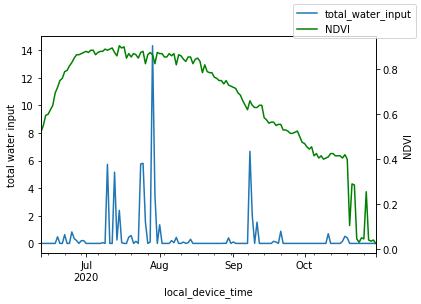

In [ ]:
#plotting against a dual y axis

ax = plot_11.plot( y='total_water_input', legend=False, ylabel = 'total water input')
ax2 = ax.twinx()
plot_11.plot(y='NDVI', ax=ax2, legend=False, color="g", ylabel = 'NDVI')
ax.figure.legend()
plt.show()

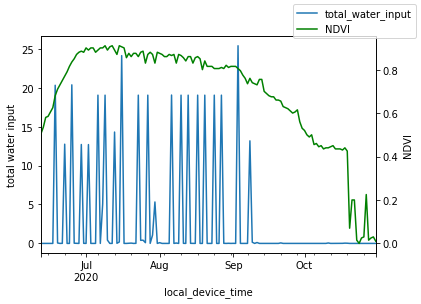

In [ ]:
#same thing for block 16 
# note how much higher NDVI is at the start of september in plot 16 vs 11 
ax = plot_16.plot( y='total_water_input', legend=False, ylabel = 'total water input')
ax2 = ax.twinx()
plot_16.plot(y='NDVI', ax=ax2, legend=False, color="g", ylabel = 'NDVI')
ax.figure.legend()
plt.show()



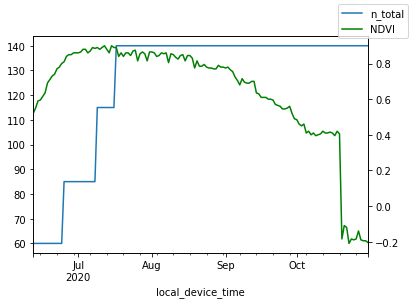

In [ ]:
#plotting N amounts 

ax = plot_3.plot( y='n_total', legend=False)
ax2 = ax.twinx()
plot_3.plot(y='NDVI', ax=ax2, legend=False, color="g")
ax.figure.legend()
plt.show()

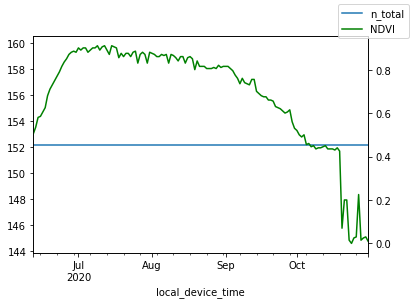

In [ ]:
#plotting against a dual y axis

ax = plot_11.plot( y='n_total', legend=False)
ax2 = ax.twinx()
plot_16.plot(y='NDVI', ax=ax2, legend=False, color="g")
ax.figure.legend()
plt.show()

In [ ]:

#plot_11.plot(kind= 'scatter', y ='total_water_input', alpha=0.2);
plot_11.plot(y =['total_water_input','NDVI'], figsize=(10,5), grid=True)
plot_16.plot(y =['total_water_input','NDVI'], figsize=(10,5), grid=True)
plot_3.plot(y =['total_water_input', 'NDVI'], figsize=(10,5), grid=True)
plot_5.plot(y =['total_water_input', 'NDVI'], figsize=(10,5), grid=True)

In [ ]:
#new = old.filter(['A','B','D'], axis=1)

features = ['NDVI', 'ETc', 'precip','water_balance','max_temp','irr_amount','n_total','total_water_input','tbelow','air_temp','ndvi_ratio','irr_total','vapor_pressure_deficit','CWSI']
plot11pred = plot_11.filter(features)

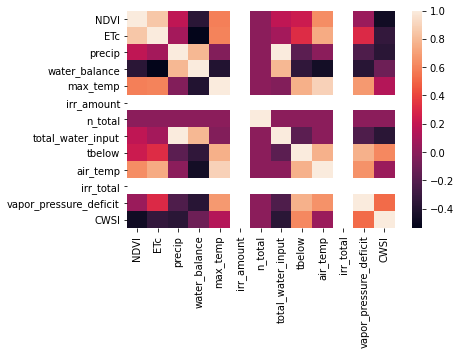

In [ ]:
#building correlation matrix
sns.heatmap(plot_11.filter(features).corr())


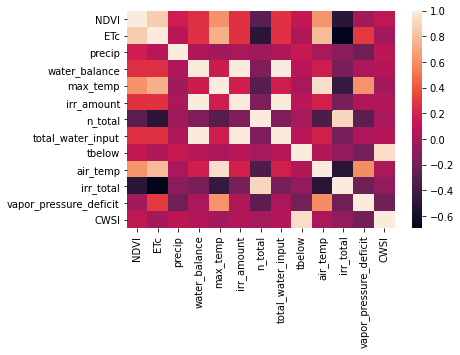

In [ ]:
sns.heatmap(plot_16.filter(features).corr())


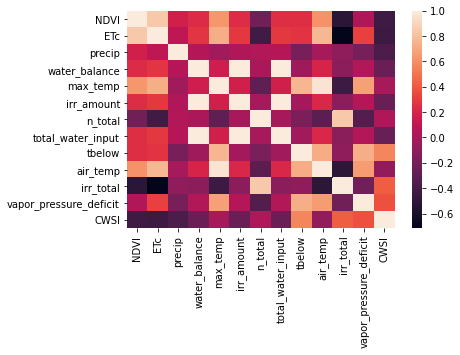

In [ ]:
sns.heatmap(plot_3.filter(features).corr())


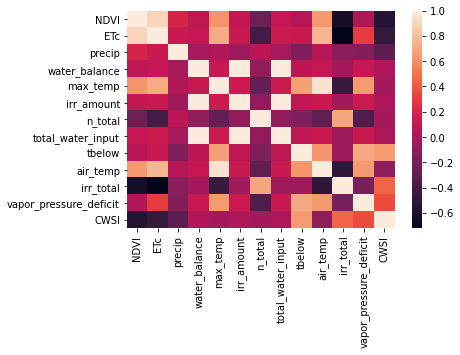

In [ ]:
sns.heatmap(plot_5.filter(features).corr())

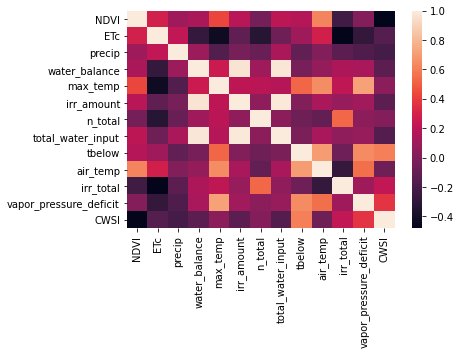

In [ ]:
sns.heatmap(all_plots.filter(features).corr())

**SIMPLE LINEAR REGRESSION**

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Create X and y.
feature_cols = ['tbelow']
X = all_plots[feature_cols]
y = all_plots['CWSI']

In [ ]:
# Check X's type.
print((type(X)))
print((type(X.values)))
# Check y's type.
print((type(y)))
print((type(y.values)))
print((X.shape))
print((y.shape))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
(142, 1)
(142,)


In [ ]:
# Make an instance of a LinearRegression object. Step 2 
lr = LinearRegression()
type(lr)

sklearn.linear_model._base.LinearRegression

In [ ]:
lr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#Step 3 Fit the model with data 
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Per future warning, one-dimensional arrays must be reshaped using the following.
lr.predict(np.array([0]).reshape(1,-1))

array([0.12855009])

In [ ]:
#Let's ask the model to make two predictions, one when the tbelow is 10 and another when the tbelow is 25.
# To do this, our feature matrix is always a 2-D array where each row is a list of features.
# Since we only have a single feature, the teetcmperature, each row will contain only a single value.

X_new = [[10], [30]]
lr.predict(X_new)



array([0.38823054, 0.90759144])

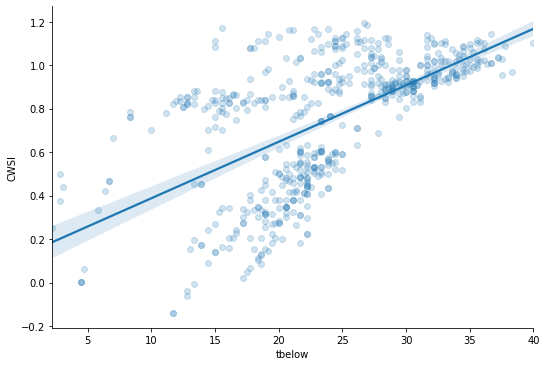

In [ ]:
#sns.lmplot(x='lfairdelta', y='CWSI', data=plot_11, aspect=1.5, scatter_kws={'alpha':0.2});
sns.lmplot(x='tbelow', y='CWSI', data=all_plots, aspect=1.5, scatter_kws={'alpha':0.2});

*What* we just predicted using our model is, "If the tbelow is 10 , the total number of cwsi will be  .3 (nonwaterstressed), and if the tbelow is 30 the cwsi will be ~.87 (waterstressed)

In [ ]:
# Import, instantiate, fit.
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Print the coefficients.
#the intercept ( β0β0 )
print(linreg.intercept_)
# the "tbelow" coefficient ( β1β1 ):
print(linreg.coef_)

0.14946049076555823
[0.02429335]


slight increase in tbelow = increase in cwsi by xxx?

**WORKING WITH MULTIPLE FEATURES FOR MULTIPLE LINEAR REGRESSION**

1.   List item
2.   List item



In [ ]:
# Create feature column variables to test on specific features
feature_cols = ['water_balance','swdw','vapor_pressure_deficit','max_temp','irr_amount','tbelow']

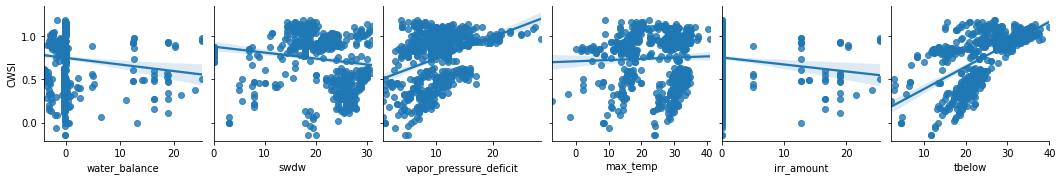

In [ ]:
# Multiple scatterplots in Seaborn to get a sense of what the data looks like
sns.pairplot(all_plots, x_vars=feature_cols, y_vars='CWSI', kind='reg');

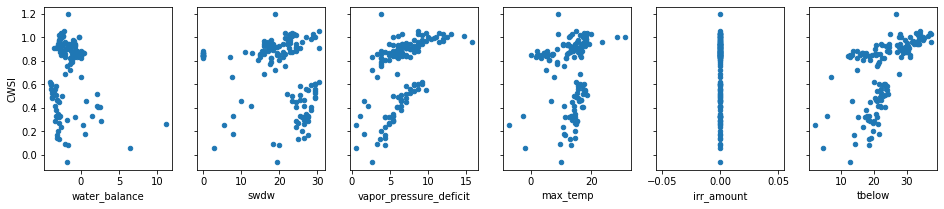

In [ ]:
#same thing in pandas
# Multiple scatterplots in Pandas
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    plot_11.plot(kind='scatter', x=feature, y='CWSI', ax=axs[index], figsize=(16, 3))

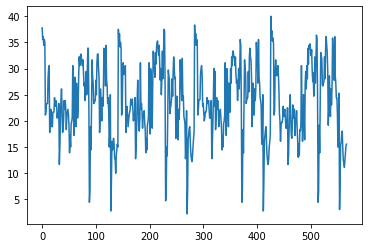

In [ ]:
# Line plot of tbelow
#need to get time on x axis
all_plots.tbelow.plot();

In [ ]:
# Correlation matrix (ranges from 1 to -1)
plot_11.corr()

In [ ]:

#creating another linear regression

# Create X and y.
X = all_plots[feature_cols]
y = all_plots.CWSI

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

0.33611937809898423
[ 0.02243151 -0.01369305  0.01338693 -0.01202156 -0.02463173  0.03563763]


In [ ]:
#displaying linear regression with feature names
# Pair the feature names with the coefficients.
list(zip(feature_cols, linreg.coef_))

[('water_balance', 0.022431508803783577),
 ('swdw', -0.013693051012588237),
 ('vapor_pressure_deficit', 0.01338693293999892),
 ('max_temp', -0.012021557287283482),
 ('irr_amount', -0.024631725584909343),
 ('tbelow', 0.03563763452924194)]

In [ ]:
#Interpreting the coefficients...
#1 unit increase in CWSI is associate with 0.038147 increase in tbelow.

TESTING FOR MULTICOLINEARITY

> Multicollinearity happens when two or more features are highly correlated with each other. The problem is that due to the high correlation, it's hard to disambiguate which feature has what kind of effect on the outcome. In other words, the features mask each other.

There is a second related issue called variance inflation where including correlated features increases the variability of our model and p-values by widening the standard errors. This can be measured with the variance inflation factor, which we will not cover here.



                   max_temp       ETc  crop_water_demand  irr_amount
max_temp           1.000000  0.603614          -0.396179         NaN
ETc                0.603614  1.000000          -0.538103         NaN
crop_water_demand -0.396179 -0.538103           1.000000         NaN
irr_amount              NaN       NaN                NaN         NaN
AxesSubplot(0.125,0.125;0.62x0.755)


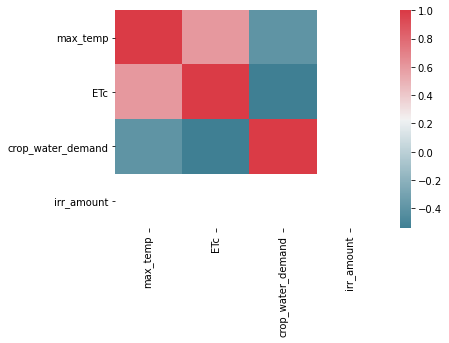

In [ ]:
'''
cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = plot_11[['max_temp', 'ETc','crop_water_demand','irr_amount']].corr()
print(correlations)
print(sns.heatmap(correlations, cmap=cmap))
'''

Evaluate performance : need to determine which features to use using train test split
Looking at MAE, MSE, RMSE as way to minimize loss/error

**TRAIN TEST SPLIT CODE**

In [ ]:
#another linear regression but including train test split

from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split

# Define a function that accepts a list of features and returns testing RMSE.
def train_test_rmse(plot_11, feature_cols):
    X = plot_11[feature_cols]
    y = plot_11.CWSI
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [ ]:
# Compare different sets of features.
#adding features reduces rmse between regression line and actual cwsi values
print(train_test_rmse(plot_11, ['max_temp', 'water_balance']))
print(train_test_rmse(plot_11, ['max_temp', 'crop_water_demand','tbelow']))
print(train_test_rmse(plot_11, ['max_temp', 'water_balance','tbelow','air_temp']))

0.28038605486273527
0.17093945338350655
0.10856676266591662


In [ ]:
#coefficients come out different than after they do without splitting the data
list(zip(feature_cols, linreg.coef_))

[('water_balance', -0.007629676822790739),
 ('swdw', -0.009324517828673887),
 ('vapor_pressure_deficit', 0.026983494876949943),
 ('max_temp', -0.02911665555353555),
 ('irr_amount', 0.0),
 ('tbelow', 0.038147445549935315)]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
#TO UNDERSTAND SHAPE

# Before splitting
print(X.shape)

# After splitting
print(X_train.shape)
print(X_test.shape)

(142, 6)
(106, 6)
(36, 6)


In [ ]:
# Recall that (1,) is a tuple.
# The trailing comma distinguishes it as being a tuple, not an integer.

# Before splitting
print(y.shape)

# After splitting
print(y_train.shape)
print(y_test.shape)

(142,)
(106,)
(36,)


ADDING A RANDOM STATE VARIABLE
Answer why we need to do this


In [ ]:
# WITHOUT a random_state parameter:
#  (If you run this code several times, you get different results!)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Print the first element of each object.
print(X_train.head(1))

                   Intercept    tbelow
local_device_time                     
2020-10-19               1.0  6.944444


In [ ]:
# WITH a random_state parameter:
#  (Same split every time! Note you can change the random state to any integer.)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Print the first element of each object.
print(X_train.head(1))
print(X_test.head(1))
print(y_train.head(1))
print(y_test.head(1))

                   Intercept     tbelow
local_device_time                      
2020-06-30               1.0  18.888889
                   Intercept     tbelow
local_device_time                      
2020-08-29               1.0  27.777778
                     CWSI
local_device_time        
2020-06-30         0.4503
                   CWSI
local_device_time      
2020-08-29          1.0


INTRODUCING PATSY
We will make one more modification. Patsy is a library that allows you to quickly perform simple data transformations in a style similar to R.

Rather than manually creating X and y, we will use the .dmatricies() function from Patsy to create the matricies and explore the effect of changing features on training and testing error.


In [ ]:
import patsy

In [ ]:
feature_cols

['water_balance',
 'swdw',
 'vapor_pressure_deficit',
 'max_temp',
 'irr_amount',
 'tbelow']

In [ ]:
y, X = patsy.dmatrices("CWSI ~ tbelow", data=plot_11, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#test the model on the testing set and check for accuracy
y_pred = lr.predict(X_test)

print(metrics.mean_squared_error(y_train, lr.predict(X_train)))
print(metrics.mean_squared_error(y_test, y_pred))

0.052658234009806903
0.03623760985916406


In [ ]:

# Store the predicted response values.
y_pred = lr.predict(X)


To evaluate a model, we also need an evaluation metric:

A numeric calculation used to quantify the performance of a model.
The appropriate metric depends on the goals of your problem.
The most common choices for regression problems are:

R-squared: The percentage of variation explained by the model (a "reward function," as higher is better).
Mean squared error: The average squared distance between the prediction and the correct answer (a "loss function," as lower is better).
In this case, we'll use mean squared error because it is more interpretable in a predictive context.

**MODEL EVALUATION**

In [ ]:
from sklearn import metrics

print(metrics.mean_squared_error(y, y_pred))

# attempted won't be in paper

0.048495258873024215


KFOLDS CROSS VALIDATION


1. Split our data into a number of different pieces (folds).
2. Train using `k-1` folds for training and a different fold for testing.
3. Average our model against EACH of those iterations.
4. Choose our model and TEST it against the final fold.
5. Average all test accuracies to get the estimated out-of-sample accuracy.

Although this may sound complicated, we are just training the model on k separate train-test-splits, then taking the average of the resulting test accuracies!

In [ ]:
from sklearn import model_selection
kf = model_selection.KFold(n_splits=5, shuffle=True)

In [ ]:
mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 0.0412988429464745
R2: 0.3781762615254615

Model 2
MSE: 0.048222470249556185
R2: 0.3781500699358624

Model 3
MSE: 0.06019461635799608
R2: 0.37733392430206847

Model 4
MSE: 0.05876448112594003
R2: 0.37147610231443473

Model 5
MSE: 0.04470906152459775
R2: 0.3735371960419238

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 0.05063789444091291
Mean of R2 for all folds: 0.3757347108239502


In [ ]:
from sklearn.model_selection import cross_val_score

# Note the results will vary each run since we take a different
#   subset of the data each time (since shuffle=True)
kf = model_selection.KFold(n_splits=5, shuffle=True)

print(np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(lr, X, y, cv=kf)))

0.04896930064513845
0.2585956995930824


While the cross-validated approach here generated more overall error, which of the two approaches would predict new data more accurately — the single model or the cross-validated, averaged one? Why?

**Answer**: This score will be lower with the single model in this case, but we're trading off bias error for generalized error.

**EXTRA VALIDATION**

comparing RMSE with null rmse:Null RMSE is the RMSE that could be achieved by always predicting the mean response value. It is a benchmark against which you may want to measure your regression model.

In [ ]:
Feature Selection
How do we choose which features to include in the model? We're going to use train/test split (and eventually cross-validation).

In [ ]:
#IS THIS USEFUL

# Split X and y into training and testing sets.
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Create a NumPy array with the same shape as y_test.
#y_null = np.zeros_like(y_test, dtype=float)
# y_null = np.zeros(shape=y_test.shape)
# Fill the array with the mean value of y_test.
#y_null.fill(y_test.mean())
#y_null

In [ ]:
#np.sqrt(metrics.mean_squared_error(y_test, y_null))

In [ ]:
# Compute null RMSE.
#np.sqrt(metrics.mean_squared_error(y_test, y_null))

TEST FOR BIAS AND VARIANCE WITH TTS


Linear regression: Low variance, High bias.
If we train with a different subset of the training set, the model will be about the same. Hence, the model has low variance.
The resulting model will predict the training points incorrectly (unless they happen to be perfectly linear). Hence, it has high bias.
```
# This is formatted as code
```



Ideas for testing: split into data set then run model (or perhaps run site a vs site b at one of the locations?

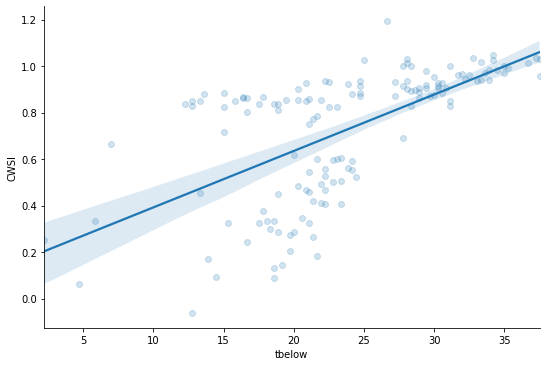

In [ ]:
sns.lmplot(x='tbelow', y='CWSI', data=plot_11, aspect=1.5, scatter_kws={'alpha':0.2});

In [ ]:
sns.lmplot(x='tbelow', y='CWSI', data=plot_5, aspect=1.5, scatter_kws={'alpha':0.2});

In [ ]:
#How to blend data from each site into the same model? This should increase accuracy since it would be more data. Would we have to make one unified data set?
#We're out of time but we can talk about why this would be useful in the paper for further research



```
### This is formatted as code
```

**Compare to logistic regression**

In [ ]:
#...but first more visualization

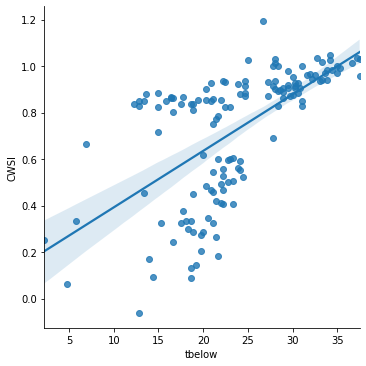

In [ ]:
#trying something else here
#Predicting ETc with tbelow
#scatter with regression line
sns.lmplot(x='tbelow', y='CWSI', data=plot_11);

if tbelow is over 25 we can be sure cwsi is high
midpoint is .6 so lets use that as the threshold for counting if water stressed or not



from this chart maybe some deduction could be made that if tbelow and etc are above a certain threshold (ie tbelow is over 30 and etc is above 2) that there is a high probablity of water stress


Recall the simple linear regression equation is  y=β0+β1xy=β0+β1x 
β0β0  is the intercept and  β1β1  is, in this case, our coefficient on the ETc predictor

In [ ]:
print(linreg.intercept_)
print(linreg.coef_)

0.14946049076555823
[0.02429335]


In [ ]:
# Compute prediction for ETC=2 using the equation.
#linreg.intercept_ + linreg.coef_[0] * 2

In [ ]:
#should yield the same result 
#use this format in above error
#linreg.predict([[2]])
#linreg.predict(2)


Coefficient interpretation: A 2-unit increase in etc is associated with a 0.05346228-unit decrease in Tbelow.

Intercept interpretation: When etc = 0, the estimated value of tbelow is 0.883745008556735 (I'm not sure if this is right)

**PREDICTING A SINGLE CATEGORICAL VARIABLE FOR CWSI**

In [ ]:
#convert from float to int
#df['Field_2'] = df['Field_2'].apply(np.int64)
plot_11['is_water_stressed']=plot_11['is_water_stressed'].apply(np.int64)
plot_16['is_water_stressed']=plot_16['is_water_stressed'].apply(np.int64)
plot_5['is_water_stressed']=plot_5['is_water_stressed'].apply(np.int64)
plot_3['is_water_stressed']=plot_3['is_water_stressed'].apply(np.int64)

In [ ]:
plot_11.is_water_stressed

local_device_time
2020-10-18    0
2020-09-08    0
2020-09-09    0
2020-10-19    0
2020-10-27    0
             ..
2020-08-24    1
2020-06-14    1
2020-09-06    1
2020-09-05    1
2020-06-12    1
Name: is_water_stressed, Length: 142, dtype: int64

Text(0, 0.5, 'is_water_stressed')

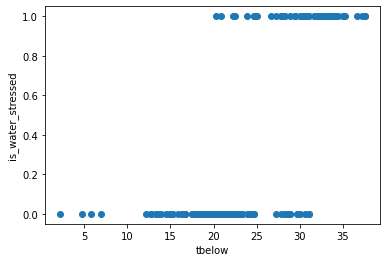

In [ ]:
plt.scatter(plot_11.tbelow, plot_11.is_water_stressed)
plt.xlabel('tbelow')
plt.ylabel('is_water_stressed')

In [ ]:
# Fit a linear regression model and store the predictions.
feature_cols = ['tbelow']
X = plot_11[feature_cols]
y = plot_11.is_water_stressed

linreg.fit(X,y)
plot_11['is_water_stressed_pred'] = linreg.predict(X)


In [ ]:
plot_11.head()

,lat,long,cl,ET,ETc,gdd,gdd_source,gdd_cumulative,gdd_cumulative_source,NDVI,min_rh,rh_at_max_temp,rh_at_min_temp,swdw,max_temp,mean_temp,min_temp,max_temp_dew,precip,precip_hours,cumulative_precip,sea_level_pressure,vapor_pressure_deficit,Kc,leaf_wetness,dew_temp,crop_water_demand,sunshine_duration,wind_speed,wind_heading,wind_speed_max,wind_speed_min,irr_amount,n_total,irr_total,total_water_input,water_balance,tbelow,air_temp,CWSI,is_water_stressed,is_water_stressed_pred
local_device_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-12,41.08725,-100.771,2.475,3.770,2.075,0.0,0.0,0.0,0.0,0.520,0.220,0.235,0.505,26.0,23.611111,13.611111,45.5,43.0,0.0,0.0,0.0,508.15,15.80,0.580,0.0,30.0,-2.075,8.5,2,0.0,9,5,0.0,152.2,0,0.0,-2.075,37.500000,34.722222,0.956418,1.0,0.986074
2020-06-13,41.08725,-100.771,2.765,3.640,2.190,0.0,0.0,0.0,0.0,0.550,0.335,0.355,0.900,30.5,15.000000,9.166667,34.0,36.5,0.0,0.0,0.0,504.85,8.70,0.630,0.0,34.0,-2.190,11.2,3,0.0,15,6,0.0,152.2,0,0.0,-2.190,34.166667,27.777778,1.048537,1.0,0.832146
2020-06-14,41.08725,-100.771,3.165,3.430,2.295,0.0,0.0,0.0,0.0,0.595,0.220,0.225,0.425,23.5,18.333333,12.500000,45.0,33.5,0.0,0.0,0.0,502.10,14.70,0.695,0.0,29.5,-2.295,10.6,4,0.0,19,4,0.0,152.2,0,0.0,-2.295,36.666667,31.111111,1.011718,1.0,0.947592
2020-06-15,41.08725,-100.771,3.205,3.690,2.505,0.0,0.0,0.0,0.0,0.600,0.210,0.220,0.510,29.0,18.333333,12.222222,45.0,34.0,0.0,0.0,0.0,504.25,13.05,0.700,0.0,31.5,-2.505,10.8,3,0.0,15,5,0.0,152.2,0,0.0,-2.505,34.166667,28.055556,1.027005,1.0,0.832146
2020-06-16,41.08725,-100.771,3.530,3.795,2.660,0.0,0.0,0.0,0.0,0.620,0.295,0.300,0.610,29.5,17.222222,11.666667,43.5,36.0,0.0,0.0,0.0,502.65,12.50,0.735,0.0,33.0,-2.660,11.0,5,0.0,22,13,0.0,152.2,0,0.0,-2.660,35.000000,30.000000,1.000000,1.0,0.870628


Text(0, 0.5, 'is_water_stressed')

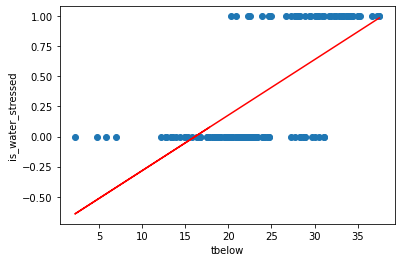

In [ ]:
# Scatter plot that includes the regression line
#plt.scatter(plot_11.tbelow, plot_11.CWSI)(use is water stressed instead of cwsi so its binary)
plt.scatter(plot_11.tbelow, plot_11.is_water_stressed)
plt.plot(plot_11.tbelow, plot_11.is_water_stressed_pred, color='red')
plt.xlabel('tbelow')
plt.ylabel('is_water_stressed')


if tbelow is 35 we predict water stress
if tbelow is 15 we predict no water stress

What's our cutoff value? Around **tbelow 20**, because that's where the linear regression line crosses the midpoint between predicting class 0 and class 1.

Using this threshold, create a new column of our predictions for whether a row is water stressed or not


In [ ]:
# Transform household_pred to 1 or 0.
plot_11['is_water_stressed_pred_class'] = np.where(plot_11.is_water_stressed_pred >= 0.6, 1, 0)
plot_11.head()

,lat,long,cl,ET,ETc,gdd,gdd_source,gdd_cumulative,gdd_cumulative_source,NDVI,min_rh,rh_at_max_temp,rh_at_min_temp,swdw,max_temp,mean_temp,min_temp,max_temp_dew,precip,precip_hours,cumulative_precip,sea_level_pressure,vapor_pressure_deficit,Kc,leaf_wetness,dew_temp,crop_water_demand,sunshine_duration,wind_speed,wind_heading,wind_speed_max,wind_speed_min,irr_amount,n_total,irr_total,total_water_input,water_balance,tbelow,air_temp,CWSI,is_water_stressed,is_water_stressed_pred,is_water_stressed_pred_class
local_device_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-12,41.08725,-100.771,2.475,3.770,2.075,0.0,0.0,0.0,0.0,0.520,0.220,0.235,0.505,26.0,23.611111,13.611111,45.5,43.0,0.0,0.0,0.0,508.15,15.80,0.580,0.0,30.0,-2.075,8.5,2,0.0,9,5,0.0,152.2,0,0.0,-2.075,37.500000,34.722222,0.956418,1.0,0.986074,1
2020-06-13,41.08725,-100.771,2.765,3.640,2.190,0.0,0.0,0.0,0.0,0.550,0.335,0.355,0.900,30.5,15.000000,9.166667,34.0,36.5,0.0,0.0,0.0,504.85,8.70,0.630,0.0,34.0,-2.190,11.2,3,0.0,15,6,0.0,152.2,0,0.0,-2.190,34.166667,27.777778,1.048537,1.0,0.832146,1
2020-06-14,41.08725,-100.771,3.165,3.430,2.295,0.0,0.0,0.0,0.0,0.595,0.220,0.225,0.425,23.5,18.333333,12.500000,45.0,33.5,0.0,0.0,0.0,502.10,14.70,0.695,0.0,29.5,-2.295,10.6,4,0.0,19,4,0.0,152.2,0,0.0,-2.295,36.666667,31.111111,1.011718,1.0,0.947592,1
2020-06-15,41.08725,-100.771,3.205,3.690,2.505,0.0,0.0,0.0,0.0,0.600,0.210,0.220,0.510,29.0,18.333333,12.222222,45.0,34.0,0.0,0.0,0.0,504.25,13.05,0.700,0.0,31.5,-2.505,10.8,3,0.0,15,5,0.0,152.2,0,0.0,-2.505,34.166667,28.055556,1.027005,1.0,0.832146,1
2020-06-16,41.08725,-100.771,3.530,3.795,2.660,0.0,0.0,0.0,0.0,0.620,0.295,0.300,0.610,29.5,17.222222,11.666667,43.5,36.0,0.0,0.0,0.0,502.65,12.50,0.735,0.0,33.0,-2.660,11.0,5,0.0,22,13,0.0,152.2,0,0.0,-2.660,35.000000,30.000000,1.000000,1.0,0.870628,1


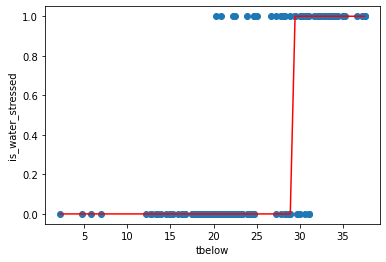

In [ ]:
# sort so we can have a continuous line
plot_11.sort_values('tbelow', inplace=True)
# Plot the class predictions.
plt.scatter(plot_11.tbelow, plot_11.is_water_stressed)

plt.xlabel('tbelow')
plt.ylabel('is_water_stressed')

plt.plot(plot_11.tbelow, plot_11.is_water_stressed_pred_class, color='red')

**using logistic regression for classification**

Logistic regression is a more appropriate method for what we just did with a linear regression. The values output from a linear regression cannot be interpreted as probabilities of class membership since their values can be greater than 1 and less than 0. Logistic regression, on the other hand, ensures that the values output as predictions can be interpreted as probabilities of class membership.

In [ ]:
# Fit a logistic regression model and store the class predictions.
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

feature_cols = ['tbelow']
X = plot_11[feature_cols]
y = plot_11.is_water_stressed

logreg.fit(X,y)
pred = logreg.predict(X)

Text(0, 0.5, 'is_water_stressed')

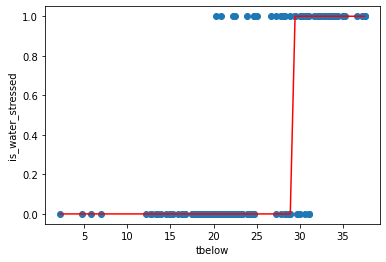

In [ ]:
#plt.scatter(plot_11.tbelow, plot_11.CWSI)(use is water stressed instead of cwsi so its binary)
plt.scatter(plot_11.tbelow, plot_11.is_water_stressed)
plt.plot(plot_11.tbelow, plot_11.is_water_stressed_pred_class, color='red')
plt.xlabel('tbelow')
plt.ylabel('is_water_stressed')

What if we wanted the predicted probabilities instead of just the class predictions, to understand how confident we are in a given prediction?

**Using the built-in `.predict_proba()` function, examine the predicted probabilities for the first handful of rows of `X`.**

In [ ]:
# brackets changes days used
logreg.predict_proba(X)[100:110]

array([[0.37693951, 0.62306049],
       [0.37693951, 0.62306049],
       [0.35097897, 0.64902103],
       [0.32587126, 0.67412874],
       [0.32587126, 0.67412874],
       [0.32587126, 0.67412874],
       [0.27862777, 0.72137223],
       [0.27862777, 0.72137223],
       [0.27862777, 0.72137223],
       [0.2566491 , 0.7433509 ]])

Sklearn orders the columns according to our class labels. The two-column output of `predict_proba` returns a column for each class of our `is_water_stressed` variable. The first column is the probability of `is_water_stressed=0` for a given row, and the second column is the probability of `is_water_stressed=1`.

**Store the predicted probabilities of class=1 in its own column in the data set.**

In [ ]:
# Store the predicted probabilities of class 1.
plot_11['is_water_stressed_prob'] = logreg.predict_proba(X)[:, 1]

In [ ]:
plot_11.head(2)

,lat,long,cl,ET,ETc,gdd,gdd_source,gdd_cumulative,gdd_cumulative_source,NDVI,min_rh,rh_at_max_temp,rh_at_min_temp,swdw,max_temp,mean_temp,min_temp,max_temp_dew,precip,precip_hours,cumulative_precip,sea_level_pressure,vapor_pressure_deficit,Kc,leaf_wetness,dew_temp,crop_water_demand,sunshine_duration,wind_speed,wind_heading,wind_speed_max,wind_speed_min,irr_amount,n_total,irr_total,total_water_input,water_balance,tbelow,air_temp,CWSI,is_water_stressed,is_water_stressed_pred,is_water_stressed_pred_class,is_water_stressed_prob
local_device_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-18,41.08725,-100.771,2.455,0.315,0.155,0.0,0.0,0.0,0.0,0.42,0.590,0.610,0.860,5.5,-7.222222,-8.888889,13.5,16.0,0.515,2.5,64.435,509.1,0.55,0.445,7.5,12.5,0.360,4.10,2,0.0,13,4,0.0,152.2,0,0.515,0.360,2.222222,0.555556,0.250936,0.0,-0.642992,0,0.000044
2020-09-08,41.08725,-100.771,5.380,0.260,0.205,0.0,0.0,0.0,0.0,0.66,0.715,0.795,0.885,3.0,-1.944444,-5.277778,20.5,24.0,6.670,10.0,58.395,510.2,0.55,0.795,14.5,19.5,6.415,0.95,4,0.0,18,10,0.0,152.2,0,6.670,6.465,4.722222,3.888889,0.063670,0.0,-0.527547,0,0.000119


Text(0, 0.5, 'is_water_stressed')

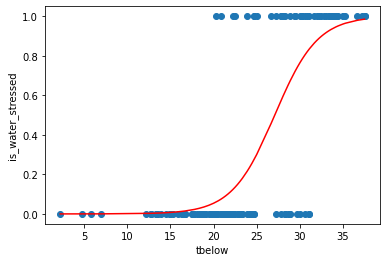

In [ ]:
# Plot the predicted probabilities as tbelow changes
plt.scatter(plot_11.tbelow, plot_11.is_water_stressed)
plt.plot(plot_11.tbelow, plot_11.is_water_stressed_prob, color='red')
plt.xlabel('tbelow')
plt.ylabel('is_water_stressed')

In [ ]:
#trying to examine some example predictions.
# Have to give double brackets for propper formatting 
print(logreg.predict_proba([[1]]))
print(logreg.predict_proba(2))
print(logreg.predict_proba(3))

[[9.99973436e-01 2.65635441e-05]]


ValueError: ignored

**## Interpreting Logistic Regression Coefficients**

Text(0, 0.5, 'is_water_stressed')

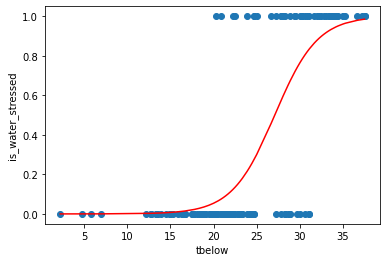

In [ ]:
## Plot the predicted probabilities again.

plt.scatter(plot_11.tbelow, plot_11.is_water_stressed)
plt.plot(plot_11.tbelow, plot_11.is_water_stressed_prob, color='red')
plt.xlabel('tbelow')
plt.ylabel('is_water_stressed')

Remember:

log(p1−p)=β0+β1x
log⁡(p1−p)=β0+β1x
 
That means we'll get out the log odds if we compute the intercept plus the coefficient times a value for TBELOW.

In [ ]:
# Compute predicted log odds for tbelow = 20 using the equation. This number can be changed for whatever value we are trying to predict for. 
logodds = logreg.intercept_ + logreg.coef_[0] * 20
logodds

array([-2.86283841])

Now that we have the log odds, we will need to go through the process of converting these log odds to probability.

Convert the log odds to odds, then the odds to probability

In [ ]:
# Convert log odds to odds.
odds = np.exp(logodds)
odds

array([0.05710644])

In [ ]:
# Convert odds to probability.
prob = odds/(1 + odds)
prob

array([0.05402147])

This finally gives us the predicted probability of `is_water_stressed=1` when `tbelow=20`. (or whatever other number we enter in the code above. You can confirm this is the same as the value you would get out of the `.predict_proba()` method of the sklearn object.

In [ ]:
# Compute predicted probability for tbelow=2 using the predict_proba method.
#we really need to fix the array shape
logreg.predict_proba([[20]])

array([[0.94597853, 0.05402147]])

In [ ]:
# Examine the coefficient for tbelow.
list(zip(feature_cols, logreg.coef_[0]))

[('tbelow', 0.40384767532882004)]

In [ ]:
# Print the intercept.
logreg.intercept_

array([-10.93979192])

**Interpretation:** A 1-unit increase in `tbelow` is associated with a 0.4-unit (logreg.coef two cells up) increase in the log odds of `is_water_stressed`.

In [ ]:
# Increasing al by 10 (so that tbelow=30)
#logodds = logreg.intercept + logreg.coeff
logodds = -10.939791926 + 0.40384767532882004*30
odds = np.exp(logodds)
prob = odds/(1 + odds)
prob

0.7641626585049813

prob of is_water stressed is much higher when tbelow is 30


In [ ]:
# Compute predicted probability for tbelow=30 using the predict_proba method.
logreg.predict_proba([[30]])

array([[0.23583734, 0.76416266]])

In [ ]:
print([[30]])
print(np.shape([[30]]))

[[30]]
(1, 1)


In [ ]:
# Examine the intercept.
logreg.intercept_

array([-10.93979192])

**Intercept interpretation:** For an `tbelow` value of 0, the log-odds of `is_water_stressed` is -4.12790736.

In [ ]:
# Convert log odds to probability.
logodds = logreg.intercept_
odds = np.exp(logodds)
prob = odds/(1 + odds)
prob

array([1.77378523e-05])

**Bottom line:** Positive coefficients increase the log odds of the response (and thus increase the probability), and negative coefficients decrease the log odds of the response (and thus decrease the probability).

In [ ]:
#USING LOGISTIC REGRESSION FOR PREDICTION

this graph shows that there are some cases above the tbelow threshold that it doesnt predict as water stressed; perhaps it could be better predicted if we adjusted by time of the season/growth stage. 

What if we wanted the predicted probabilities instead of just the class predictions, to understand how confident we are in a given prediction?

**Using the built-in `.predict_proba()` function, examine the predicted probabilities for the first handful of rows of `X`.**

Sklearn orders the columns according to our class labels. The two-column output of `predict_proba` returns a column for each class of our `is_water_stress` variable. The first column is the probability of `is_water_stress=0` for a given row, and the second column is the probability of `is_water_stress=1`.



In [ ]:
#logreg = LogisticRegression()
#feature_cols = ['tbelow']
#X = plot_11[feature_cols]
#this y could be replaced with CWSI
#y = plot_11.is_water_stressed 
# I think you need to scale this value to be between 0 and 1 may be a way to specify it in the call otherwise, FunctionTransformer is a good tool to look into


What if we wanted the predicted probabilities instead of just the class predictions, to understand how confident we are in a given prediction?

Using the built-in .predict_proba() function, examine the predicted probabilities for the first handful of rows of X.

the first column above will return cwsi=0, the second will return cwsi=1

Linear regression: Continuous response is modeled as a linear combination of the features.

y=β0+β1x
y=β0+β1x
 
Logistic regression: Log odds of a categorical response being "true" (1) is modeled as a linear combination of the features.

log(p1−p)=β0+β1x
log⁡(p1−p)=β0+β1x
 
This is called the logit function.

Probability is sometimes written as pi.

log(π1−π)=β0+β1x
log⁡(π1−π)=β0+β1x
 
The equation can be rearranged into the logistic function.

p̂ =eβ0+β1x1+eβ0+β1x
p^=eβ0+β1x1+eβ0+β1x